In [3]:
import math
import numpy as np
import time
import matplotlib.pyplot as plt
import sympy as sp
import C_GMRES_sympy as C
# sympy関数のnumpyへの変換
def numpyfy(arg,f):
    return sp.lambdify(arg, f, "numpy")


# 変数とそのベクトル化

In [52]:
#モデル変数
x, y,z= sp.symbols('x y z')
xt,yt,zt=sp.symbols('xt yt zt')
ux, uy= sp.symbols('ux uy')
lmx,lmy,lmz=sp.symbols('lmx lmy lmz')
x_ob,y_ob,z_ob=sp.symbols('x_ob,y_ob,z_ob')

#vector化
u=sp.Matrix([ux,uy])
xs=sp.Matrix([x,y,z])
obs=sp.Matrix([x_ob,y_ob,z_ob])
xbar=sp.Matrix([x-x_ob,y-y_ob,z-z_ob])
t=sp.Matrix([xt,yt,zt])
lm=sp.Matrix([lmx,lmy,lmz])

In [ ]:
#定数
umass=1
Q = sp.Matrix([[100, 0, 0],
                [0, 100, 0],
                [0, 0, 0]])
R = sp.Matrix([[umass, 0],
                [0, umass]])

S = sp.Matrix([[100, 0, 0],
                [0, 100, 0],
                [0, 0, 0]])
barcoef=0.15 

umax=sp.Matrix([15,15])
umin=-umax

carR = 0.05
carT = 0.2
r = carR/2
rT = carR/carT


# コントローラー側の運動方程式とその導関数

In [60]:
f=sp.Matrix([r*sp.cos(z)*(ux+uy),r*sp.sin(z) *(ux+uy),rT*(ux-uy)])
f

Matrix([
[0.025*(ux + uy)*cos(z)],
[0.025*(ux + uy)*sin(z)],
[     0.25*ux - 0.25*uy]])

In [54]:
fu=sp.Matrix([f.diff(ux).T,f.diff(uy).T]).T
fu

Matrix([
[0.025*cos(z), 0.025*cos(z)],
[0.025*sin(z), 0.025*sin(z)],
[        0.25,        -0.25]])

## Numpy化された関数

In [57]:
from sympy.utilities.lambdify import lambdastr
lambdastr((xs,u),f)

'lambda _0,_1: (lambda x,y,z,ux,uy: (ImmutableDenseMatrix([[0.025*(ux + uy)*math.cos(z)], [0.025*(ux + uy)*math.sin(z)], [0.25*ux - 0.25*uy]])))(_0[0],_0[1],_0[2],_1[0],_1[1])'

# 評価関数 (Hamiltonian)

In [58]:
J=(u.T*R*u+ xbar.T*Q*xbar+t.T*S*t)/2
lu=(umax - u).applyfunc(sp.log)+(u-umin).applyfunc(sp.log)
barrier=sp.Matrix([lu[0]+lu[1]]) #障壁関数
H= J + f.T*lm  +barcoef*barrier
H

Matrix([[0.025*lmx*(ux + uy)*cos(z) + 0.025*lmy*(ux + uy)*sin(z) + lmz*(0.25*ux - 0.25*uy) + ux**2/2 + uy**2/2 + 50*xt**2 + 50*yt**2 + (x - x_ob)*(100*x - 100*x_ob)/2 + (y - y_ob)*(100*y - 100*y_ob)/2 + 0.15*log(15 - ux) + 0.15*log(15 - uy) + 0.15*log(ux + 15) + 0.15*log(uy + 15)]])

In [61]:
Hu=sp.Matrix([H.diff(ux),H.diff(uy)])
Hx=sp.Matrix([H.diff(x),H.diff(y),H.diff(z)])
Ht=sp.Matrix([H.diff(xt),H.diff(yt),H.diff(zt)])

In [62]:
Hu

Matrix([
[0.025*lmx*cos(z) + 0.025*lmy*sin(z) + 0.25*lmz + ux + 0.15/(ux + 15) - 0.15/(15 - ux)],
[0.025*lmx*cos(z) + 0.025*lmy*sin(z) - 0.25*lmz + uy + 0.15/(uy + 15) - 0.15/(15 - uy)]])

In [63]:
Hx

Matrix([
[                                        100*x - 100*x_ob],
[                                        100*y - 100*y_ob],
[-0.025*lmx*(ux + uy)*sin(z) + 0.025*lmy*(ux + uy)*cos(z)]])

In [64]:
Ht

Matrix([
[100*xt],
[100*yt],
[     0]])

# Test

In [28]:
def test(maxTime,nonholo_car,ctrl,x_ob):
    Time = 0
    start = time.time()
    xs=[]
    us=[]

    while Time <= maxTime:
        xs.append(ctrl.x)
        us.append(ctrl.u)
        x = ctrl.x + nonholo_car.func(ctrl.u, ctrl.x)*ctrl.Ts
        ctrl.Time = Time + ctrl.Ts
        ctrl.CGMRES_control()
        Time += ctrl.Ts
        ctrl.x = x
    end = time.time()
    print("計算時間：{}[s]".format(end - start))
    xs=np.array(xs).reshape(len(xs),3)
    us=np.array(us).reshape(len(us),2)

    for i,l in enumerate(['x', 'y', 'z']):
        plt.plot(xs[:,i], label=l)
    plt.legend()
    plt.show()

    for i,l in enumerate(['ux', 'uy', ]):
        plt.plot(us[:,i], label=l)
    plt.legend()
    plt.show()
        

計算時間：4.255019664764404[s]


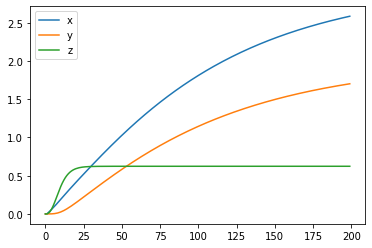

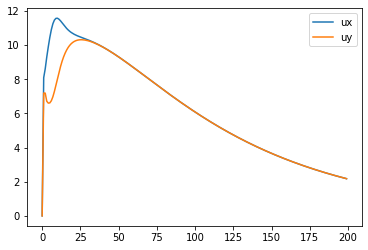

In [29]:
x_ob = np.array([3, 2, 0]).T
car = C.car(carR,carT)
ctrl = C.controller(nonholo_car, x_ob,f,H)
test(10,car,ctrl,x_ob)


計算時間：3.8549699783325195[s]


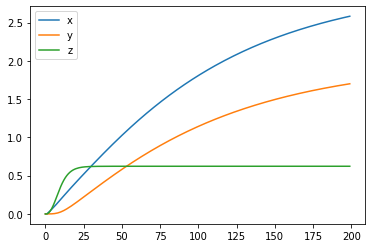

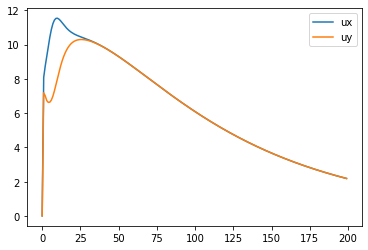

In [33]:
import C_GMRES as simple
x_ob = np.array([3, 2, 0]).T
car = simple.car()
ctrl = simple.controller(nonholo_car, x_ob)
test(10,car,ctrl,x_ob)

非sympy版と比べると計算時間がかかってしまっている